In [1]:
import os
import xarray as xr
from matplotlib import pyplot as plt
from scipy.stats import pearsonr

In [25]:
# Mask to NPAC and strip outside data
NPAC_mask = xr.open_dataarray('/glade/derecho/scratch/jzweifel/Regional_Masks_And_Area/masks/NPO/satellite_NPO_binary.nc')
new_mask = NPAC_mask.where(NPAC_mask.lat>20).fillna(0)

In [26]:
satellite_coords = xr.open_dataset('aerosol_forcing/all-sky_aerosol_forcing_ANN.nc')

satellite_DJF = xr.open_dataset('aerosol_forcing/all-sky_aerosol_forcing_DJF.nc')['AOD_pollution'].transpose('lat', 'lon').assign_coords(lat = satellite_coords['latitude'], lon = satellite_coords['longitude']).where(new_mask, drop=True).mean(dim=['lat', 'lon'])
satellite_MAM = xr.open_dataset('aerosol_forcing/all-sky_aerosol_forcing_MAM.nc')['AOD_pollution'].transpose('lat', 'lon').assign_coords(lat = satellite_coords['latitude'], lon = satellite_coords['longitude']).where(new_mask, drop=True).mean(dim=['lat', 'lon'])
satellite_JJA = xr.open_dataset('aerosol_forcing/all-sky_aerosol_forcing_JJA.nc')['AOD_pollution'].transpose('lat', 'lon').assign_coords(lat = satellite_coords['latitude'], lon = satellite_coords['longitude']).where(new_mask, drop=True).mean(dim=['lat', 'lon'])
satellite_SON = xr.open_dataset('aerosol_forcing/all-sky_aerosol_forcing_SON.nc')['AOD_pollution'].transpose('lat', 'lon').assign_coords(lat = satellite_coords['latitude'], lon = satellite_coords['longitude']).where(new_mask, drop=True).mean(dim=['lat', 'lon'])

seasonal_satellite_AOD_pollution = [satellite_DJF, satellite_MAM, satellite_JJA, satellite_SON]

In [27]:
model_data = xr.open_dataset('/glade/work/jzweifel/data_2006/h4_concat_2006.nc')['AODSO4dn'].transpose('time', 'lat', 'lon')

# Shift model lon from (0, 360) to (-180, 180)
model_data = model_data.assign_coords(lon = (((model_data.lon + 180) % 360) - 180)).sortby('lon')

model_data_on_sat = model_data.interp(
    lat=satellite_coords['latitude'],
    lon=satellite_coords['longitude'],
    method="linear"
)

model_DJF = model_data_on_sat.sel(time=model_data_on_sat.time.dt.month.isin([2,3,4])).where(new_mask).mean(dim=['time','lat', 'lon'])
model_MAM = model_data_on_sat.sel(time=model_data_on_sat.time.dt.month.isin([5,6,7])).where(new_mask).mean(dim=['time','lat', 'lon'])
model_JJA = model_data_on_sat.sel(time=model_data_on_sat.time.dt.month.isin([8,9,10])).where(new_mask).mean(dim=['time','lat', 'lon'])
model_SON = model_data_on_sat.sel(time=model_data_on_sat.time.dt.month.isin([11,12,1])).where(new_mask).mean(dim=['time','lat', 'lon'])

seasonal_model_AODSO4dn = [model_DJF, model_MAM, model_JJA, model_SON]

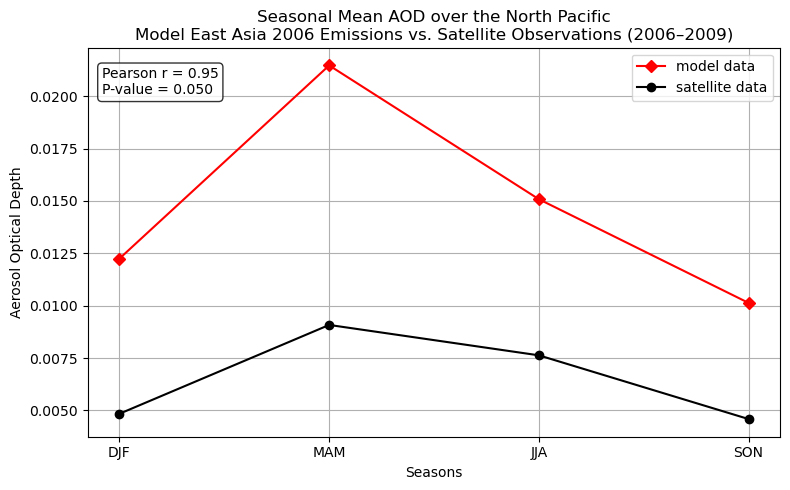

In [28]:
from matplotlib import pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(seasonal_model_AODSO4dn, marker='D', label='model data', color='red')
plt.plot(seasonal_satellite_AOD_pollution, marker='o', label='satellite data', color='black')
plt.xticks([0,1,2,3], ['DJF', 'MAM', 'JJA', 'SON'])
plt.xlabel('Seasons')
plt.ylabel('Aerosol Optical Depth')
plt.title(
    'Seasonal Mean AOD over the North Pacific\n'
    'Model East Asia 2006 Emissions vs. Satellite Observations (2006–2009)',
    fontsize=12
)
plt.grid(True)
plt.legend()

corr_coef, p_value = pearsonr(seasonal_satellite_AOD_pollution, seasonal_model_AODSO4dn)
plt.gca().text(
    0.02, 0.95,
    f"Pearson r = {corr_coef:.2f}\nP-value = {p_value:.3f}",
    transform=plt.gca().transAxes,
    fontsize=10,
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
)
plt.tight_layout()